[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/timsainb/tensorflow2-generative-models/blob/master/2.0-GAN-fashion-mnist.ipynb)

## Generative Adversarial Network (GAN)
GANs are a form of neural network in which two sub-networks generator and discriminator) are trained on opposing loss functions: an generator that is trained to produce data which is indiscernable from the true data, and a dsicriminator that is trained to discern between the data and generated data.

![gan](https://github.com/timsainb/tensorflow2-generative-models/blob/master/imgs/gan.png?raw=1)

z adalah noise yang dibangkitkan secara random, biasanya menggunakan distribusi gaussian/distribusi normal
xgen adalah gambar fake, output dari generator.
x adalah gambar asli

gambar asli dan gambar palsu ini akan diperiksa oleh diskriminator. Jika generator belum berhasil mengelabui discriminator, maka iterasi kembali ke generator lagi. Generator membuat gambar palsu yang lebih baik dari sebelumnya. Diskriminator berfungsi menilai lagi apakah gambar yang dibuat generator itu asli. Dan seterusnya, hingga tercapai nash equiblirium, saat generator mampu mengelabui diskriminator (Diskriminator mengenali gambar fake dari generator adalah gambar asli). 


### Install packages if in colab

In [ ]:
### install necessary packages if in colab
def run_subprocess_command(cmd):
    process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE)
    for line in process.stdout:
        print(line.decode().strip())


import sys, subprocess

IN_COLAB = "google.colab" in sys.modules
colab_requirements = ["pip install tf-nightly-gpu-2.0-preview==2.0.0.dev20190513"]
if IN_COLAB:
    for i in colab_requirements:
        run_subprocess_command(i)

### load packages

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
%matplotlib inline
from IPython import display
import pandas as pd

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  after removing the cwd from sys.path.


In [ ]:
print(tf.__version__)

2.7.0


### Create a fashion-MNIST dataset

In [ ]:
TRAIN_BUF=60000
BATCH_SIZE=512
TEST_BUF=10000
DIMS = (28,28,1) # Grayscale (1), RGB (3)
N_TRAIN_BATCHES =int(TRAIN_BUF/BATCH_SIZE)
N_TEST_BATCHES = int(TEST_BUF/BATCH_SIZE)

In [ ]:
# load dataset
(train_images, _), (test_images, _) = tf.keras.datasets.fashion_mnist.load_data()

# split dataset
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype(
    "float32"
) / 255.0
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype("float32") / 255.0

# batch datasets
train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_images)
    .shuffle(TRAIN_BUF)
    .batch(BATCH_SIZE)
)
test_dataset = (
    tf.data.Dataset.from_tensor_slices(test_images)
    .shuffle(TEST_BUF)
    .batch(BATCH_SIZE)
)

4431872/4422102 [==============================] - 0s 0us/step


### Define the network as tf.keras.model object

In [ ]:
class GAN(tf.keras.Model):
    """ a basic GAN class 
    Extends:
        tf.keras.Model
    """

    def __init__(self, **kwargs):
        super(GAN, self).__init__()
        self.__dict__.update(kwargs)

        self.gen = tf.keras.Sequential(self.gen)
        self.disc = tf.keras.Sequential(self.disc)

    def generate(self, z):
        return self.gen(z)

    def discriminate(self, x):
        return self.disc(x)

    def compute_loss(self, x):
        """ passes through the network and computes loss
        """
        # generating noise from a uniform distribution
        z_samp = tf.random.normal([x.shape[0], 1, 1, self.n_Z])

        # run noise through generator
        x_gen = self.generate(z_samp)
        # discriminate x and x_gen
        logits_x = self.discriminate(x)
        logits_x_gen = self.discriminate(x_gen)
        ### losses
        # losses of real with label "1"
        disc_real_loss = gan_loss(logits=logits_x, is_real=True)
        # losses of fake with label "0"
        disc_fake_loss = gan_loss(logits=logits_x_gen, is_real=False)
        disc_loss = disc_fake_loss + disc_real_loss

        # losses of fake with label "1"
        gen_loss = gan_loss(logits=logits_x_gen, is_real=True)

        return disc_loss, gen_loss

    def compute_gradients(self, x):
        """ passes through the network and computes loss
        """
        ### pass through network
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            disc_loss, gen_loss = self.compute_loss(x)

        # compute gradients
        gen_gradients = gen_tape.gradient(gen_loss, self.gen.trainable_variables)
        disc_gradients = disc_tape.gradient(disc_loss, self.disc.trainable_variables)

        return gen_gradients, disc_gradients

    def apply_gradients(self, gen_gradients, disc_gradients):

        self.gen_optimizer.apply_gradients(
            zip(gen_gradients, self.gen.trainable_variables)
        )
        self.disc_optimizer.apply_gradients(
            zip(disc_gradients, self.disc.trainable_variables)
        )
    @tf.function
    def train(self, train_x):
        gen_gradients, disc_gradients = self.compute_gradients(train_x)
        self.apply_gradients(gen_gradients, disc_gradients)
        
        
def gan_loss(logits, is_real=True):
    """Computes standard gan loss between logits and labels
    """
    if is_real:
        labels = tf.ones_like(logits)
    else:
        labels = tf.zeros_like(logits)

    return tf.compat.v1.losses.sigmoid_cross_entropy(
        multi_class_labels=labels, logits=logits
    )


### Define the network architecture

Arsitektur Discriminator mirip dengan CNN, dan arstektur generator menggunakan convolusi2DTranspose sehingga memiliki ukuran yang berkebalikan dengan diskriminator.

In [ ]:
N_Z = 64
generator = [
    tf.keras.layers.Dense(units=7 * 7 * 64, activation="relu"),
    tf.keras.layers.Reshape(target_shape=(7, 7, 64)),
    tf.keras.layers.Conv2DTranspose(
        filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=32, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=1, kernel_size=3, strides=(1, 1), padding="SAME", activation="sigmoid"
    ),
]

discriminator = [
    tf.keras.layers.InputLayer(input_shape=DIMS),
    tf.keras.layers.Conv2D(
        filters=32, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1, activation=None),
]

### Create Model

In [ ]:
# optimizers
gen_optimizer = tf.keras.optimizers.Adam(0.001, beta_1=0.5)
disc_optimizer = tf.keras.optimizers.RMSprop(0.005)# train the model
# model
model = GAN(
    gen = generator,
    disc = discriminator,
    gen_optimizer = gen_optimizer,
    disc_optimizer = disc_optimizer,
    n_Z = N_Z
)

### Train the model

In [ ]:
# exampled data for plotting results
def plot_reconstruction(model, nex=8, zm=2):
    samples = model.generate(tf.random.normal(shape=(BATCH_SIZE, N_Z)))
    fig, axs = plt.subplots(ncols=nex, nrows=1, figsize=(zm * nex, zm))
    for axi in range(nex):
        axs[axi].matshow(
                    samples.numpy()[axi].squeeze(), cmap=plt.cm.Greys, vmin=0, vmax=1
                )
        axs[axi].axis('off')
    plt.show()

In [ ]:
# a pandas dataframe to save the loss information to
losses = pd.DataFrame(columns = ['disc_loss', 'gen_loss'])

Epoch: 39 | disc_loss: 1.092509388923645 | gen_loss: 0.9672384858131409


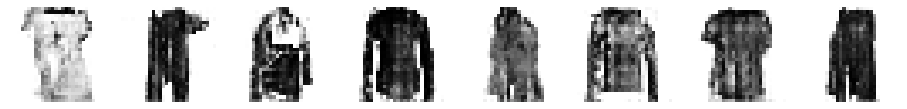

CPU times: user 2min 9s, sys: 11.3 s, total: 2min 20s
Wall time: 6min 47s


In [16]:
%%time

n_epochs = 40
for epoch in range(n_epochs):
    # train
    for batch, train_x in tqdm(
        zip(range(N_TRAIN_BATCHES), train_dataset), total=N_TRAIN_BATCHES
    ):
        model.train(train_x)
    # test on holdout
    loss = []
    for batch, test_x in tqdm(
        zip(range(N_TEST_BATCHES), test_dataset), total=N_TEST_BATCHES
    ):
        loss.append(model.compute_loss(train_x))
    losses.loc[len(losses)] = np.mean(loss, axis=0)
    # plot results
    display.clear_output()
    print(
        "Epoch: {} | disc_loss: {} | gen_loss: {}".format(
            epoch, losses.disc_loss.values[-1], losses.gen_loss.values[-1]
        )
    )
    plot_reconstruction(model)